In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Essai 1 traking images

In [ ]:
#Lister le contenu du dossier
import os

folder_path = "/content/drive/MyDrive/fluxcustomer"
files = os.listdir(folder_path)

print("Fichiers dans le dossier :", files)


In [ ]:
#vérifier l'annotation de dataset
import cv2
import os
from google.colab.patches import cv2_imshow

def draw_annotations(image_path, label_path):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        data = line.strip().split()
        class_id, x, y, width, height = map(float, data)

        # Convertir YOLO format en pixels
        x1 = int((x - width / 2) * w)
        y1 = int((y - height / 2) * h)
        x2 = int((x + width / 2) * w)
        y2 = int((y + height / 2) * h)

        # Dessiner la boîte englobante
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2_imshow(img)

def process_dataset(dataset_type):
    image_folder = f"/content/drive/MyDrive/fluxcustomer/{dataset_type}/images"
    label_folder = f"/content/drive/MyDrive/fluxcustomer/{dataset_type}/labels"

    # Lister et trier les fichiers d'annotations
    label_files = sorted(os.listdir(label_folder))[:5]

    for label_file in label_files:
        if label_file.endswith(".txt"):
            image_file = label_file.replace(".txt", ".jpg")
            image_path = os.path.join(image_folder, image_file)
            label_path = os.path.join(label_folder, label_file)

            if os.path.exists(image_path):
                draw_annotations(image_path, label_path)
            else:
                print(f"Image non trouvée pour {label_file}")

# Exécuter la fonction pour chaque dataset
for dataset in ["train", "valid", "test"]:
    print(f"\nAffichage des annotations pour {dataset}:")
    process_dataset(dataset)

**Image processing**

In [ ]:
#vérifier la taille de quelques images
import cv2
import os

# Dossier des images
image_folder = "/content/drive/MyDrive/fluxcustomer/train/images"

# Liste des fichiers images
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

# Afficher la taille des 10 premières images
for i, image_name in enumerate(image_files[:10]):  # Prendre les 10 premières images
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)

    if img is not None:
        h, w, c = img.shape  # Hauteur, largeur, nombre de canaux
        print(f"Image {i+1}: {image_name} → Taille: {w}x{h}, Canaux: {c}")
    else:
        print(f"Image {i+1}: {image_name} → Impossible de charger l'image.")

**Prétraitement → Entraînement YOLOv5**

In [ ]:
# Installation et Configuration de YOLOv5
# Clone le repo YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Installer les dépendances
%pip install -qr requirements.txt
%pip install -q roboflow

In [ ]:
#Vérifie que l'installation est correcte
import torch
print(f"Using torch {torch.__version__} ({'CUDA' if torch.cuda.is_available() else 'CPU'})")


**Prétraitement des Images et Labels (Redimensionnement 640x640)**

In [ ]:
import cv2
import os
import glob

# Fonction pour redimensionner tout en conservant les proportions
def resize_image_keep_aspect(image, target_size):
    h, w, _ = image.shape
    scale = target_size / max(h, w)  # Calcul du facteur d’échelle
    new_w, new_h = int(w * scale), int(h * scale)  # Nouvelles dimensions
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Ajouter des bordures pour atteindre 640x640
    top = (target_size - new_h) // 2
    bottom = target_size - new_h - top
    left = (target_size - new_w) // 2
    right = target_size - new_w - left

    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    return padded_image, scale, left, top

# Dossiers principaux
base_folder = "/content/drive/MyDrive/fluxcustomer"
datasets = ["train", "valid","test"]  # Appliquer le traitement sur train et valid et test

target_size = 640  # Taille cible

for dataset in datasets:
    image_folder = os.path.join(base_folder, dataset, "images")
    label_folder = os.path.join(base_folder, dataset, "labels")
    output_image_folder = os.path.join(base_folder, dataset, "resized_images")
    output_label_folder = os.path.join(base_folder, dataset, "resized_labels")

    # Assurez-vous que les dossiers de sortie existent
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)

    # Parcourir toutes les images
    image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))  # Changez l'extension si nécessaire

    for image_path in image_paths:
        filename = os.path.basename(image_path)
        label_path = os.path.join(label_folder, filename.replace(".jpg", ".txt"))

        # Charger l’image
        img = cv2.imread(image_path)
        if img is None:
            print(f" Impossible de lire {image_path}, ignoré.")
            continue

        # Redimensionner l’image
        resized_img, scale, left_pad, top_pad = resize_image_keep_aspect(img, target_size)

        # Sauvegarder l’image redimensionnée
        cv2.imwrite(os.path.join(output_image_folder, filename), resized_img)

        # Ajuster et sauvegarder l’annotation si elle existe
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                data = line.strip().split()
                class_id = data[0]
                x, y, width, height = map(float, data[1:])

                # Conversion des coordonnées avec l'échelle et le padding
                new_x = (x * img.shape[1] * scale + left_pad) / target_size
                new_y = (y * img.shape[0] * scale + top_pad) / target_size
                new_width = (width * img.shape[1] * scale) / target_size
                new_height = (height * img.shape[0] * scale) / target_size

                new_lines.append(f"{class_id} {new_x:.6f} {new_y:.6f} {new_width:.6f} {new_height:.6f}\n")

            # Sauvegarde du fichier d’annotation modifié
            with open(os.path.join(output_label_folder, filename.replace(".jpg", ".txt")), "w") as f:
                f.writelines(new_lines)

        print(f" {dataset}: {filename} redimensionné et sauvegardé !")

print(" Redimensionnement terminé pour TRAIN et VALID et TEST !")

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os

#  Dossiers des images et annotations après redimensionnement
datasets = ["train", "valid", "test"]
base_path = "/content/drive/MyDrive/fluxcustomer"

#  Fonction pour dessiner les annotations
def draw_annotations(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f" Impossible de lire {image_path}")
        return

    h, w, _ = img.shape  # Toujours 640x640 après redimensionnement

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        data = line.strip().split()
        class_id, x, y, width, height = map(float, data)

        # Convertir YOLO format en pixels
        x1 = int((x - width / 2) * w)
        y1 = int((y - height / 2) * h)
        x2 = int((x + width / 2) * w)
        y2 = int((y + height / 2) * h)

        #  Dessiner la boîte englobante
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2_imshow(img)  #  Afficher l'image annotée

#  Afficher les annotations pour chaque ensemble (train, valid, test)
for dataset in datasets:
    print(f"\n Affichage des annotations pour {dataset} \n")

    output_image_folder = os.path.join(base_path, dataset, "resized_images")
    output_label_folder = os.path.join(base_path, dataset, "resized_labels")

    if not os.path.exists(output_label_folder):
        print(f" Dossier {output_label_folder} non trouvé, passage à l'ensemble suivant...")
        continue

    #  Lister et trier les fichiers d'annotations
    label_files = sorted(os.listdir(output_label_folder))[:5]  # Ne garder que les 5 premiers fichiers

    for label_file in label_files:
        if label_file.endswith(".txt"):
            image_file = label_file.replace(".txt", ".jpg")  # Adapter selon l'extension réelle
            image_path = os.path.join(output_image_folder, image_file)
            label_path = os.path.join(output_label_folder, label_file)

            if os.path.exists(image_path):
                print(f" Affichage de {image_file} avec annotations ")
                draw_annotations(image_path, label_path)
            else:
                print(f" Image non trouvée pour {label_file}")


**Entraînement de YOLOv5 **

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/drive/MyDrive/fluxcustomer/data.yaml --weights yolov5s.pt --cache

In [ ]:
# Évaluer les performances du modèle
!python val.py --weights runs/train/exp/weights/best.pt --data /content/drive/MyDrive/fluxcustomer/data.yaml --img 640

In [ ]:
#tester une image
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --source /content/drive/MyDrive/fluxcustomer/test/images/ --conf 0.25

**Étape 2 : Suivi des clients avec DeepSORT**

In [ ]:
!git clone https://github.com/Sharpiless/Yolov5-deepsort-inference.git

%cd Yolov5-deepsort-inference
!pip install -r requirements.txt

In [ ]:
image_folder = "/content/drive/MyDrive/fluxcustomer/train/images"  # Dossier contenant les images
video_name = "/content/drive/MyDrive/fluxcustomer/output_video.mp4"  # Vidéo de sortie

images = sorted(os.listdir(image_folder))  # Trier les images par nom
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec vidéo
video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))  # 10 FPS

for image in images:
    img_path = os.path.join(image_folder, image)
    frame = cv2.imread(img_path)
    video.write(frame)

video.release()
print(f"Vidéo créée: {video_name}")

In [ ]:
from IPython.display import display, Video

video_path = "/content/drive/MyDrive/fluxcustomer/output_video.mp4"
display(Video(video_path))


In [ ]:
!git clone https://github.com/ZQPei/deep_sort_pytorch.git  # Exemple avec deep_sort_pytorch
%cd deep_sort_pytorch


!pip install numpy opencv-python scipy
import torch
print(torch.__version__)  # Affiche la version de PyTorch installée

In [ ]:
import cv2 as cv
import imutils
from deep_sort_realtime.deepsort_tracker import DeepSort

In [ ]:
# Cloner DeepSORT
!git clone https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch.git
%cd Yolov5_DeepSort_Pytorch
!pip3 install -U pip
!pip3 install -qr requirements.txt
#!pip install -r requirements.txt

In [ ]:
!wget https://github.com/KaiyangZhou/deep-person-reid/releases/download/v1.0.0/osnet_x1_0_imagenet.pth

In [ ]:
import cv2 as cv
from ultralytics import YOLO
import imutils
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np


def processVideo():
    counter_cache = []
    detection_classes = []
    count = 0
    path = "/content/drive/MyDrive/fluxcustomer/video/season-sale-with-crowd-of-people-on-escalator-in-shopping-mall-SBV-319088788-preview.mp4"

    # Lire la vidéo
    vs = cv.VideoCapture(path)

    # Charger le modèle YOLOv8
    model = YOLO('yolov8n.pt')

    # Configurer DeepSort pour le suivi
    object_tracker = DeepSort(max_iou_distance=0.7,
                               max_age=5,
                               n_init=3,
                               nms_max_overlap=1.0,
                               max_cosine_distance=0.2,
                               nn_budget=None,
                               gating_only_position=False,
                               override_track_class=None,
                               embedder="mobilenet",
                               half=True,
                               bgr=True,
                               embedder_gpu=True,
                               embedder_model_name=None,
                               embedder_wts=None,
                               polygon=False,
                               today=None
                               )

    while True:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break

        # Détection des personnes uniquement (classe 0)
        results = model.predict(frame, stream=False, classes=[0])
        print(results[0].names)
        detection_classes = results[0].names
        frame = draw_line(frame)

        for result in results:
            for data in result.boxes.data.tolist():
                id = int(data[5])

                # Vérifier si c'est une personne
                if id == 0:
                    drawBox(data, frame, detection_classes[id])
                    print("Detected Class:", detection_classes[id])

            # Obtenir les détails pour le suivi
            details = get_details(result, frame)
            tracks = object_tracker.update_tracks(details, frame=frame)

        # Suivi et comptage
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            bbox = track.to_ltrb()

            cv.putText(frame, f"ID: {track_id}", (int(bbox[0]), int(bbox[1])), cv.FONT_HERSHEY_SIMPLEX, 1,
                       (0, 255, 0), 6)
            cv.putText(frame, f"Person Count: {count}", (100, 100), cv.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 9)

            # Compter les personnes traversant la ligne
            if bbox[1] > int(frame.shape[0] / 2) and track_id not in counter_cache:
                counter_cache.append(track_id)
                count += 1
                cv.putText(frame, f"Person Count: {count}", (100, 100), cv.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 9)

        # Afficher la vidéo
        cv.imshow('image', frame)
        if cv.waitKey(30) & 0xFF == 27:  # Appuyez sur 'ESC' pour quitter
            break

    vs.release()
    cv.destroyAllWindows()


def drawBox(data, image, name):
    x1, y1, x2, y2, conf, id = data
    p1 = (int(x1), int(y1))
    p2 = (int(x2), int(y2))

    # Dessiner la boîte et afficher le nom
    cv.rectangle(image, p1, p2, (0, 0, 255), 3)
    cv.putText(image, name, p1, cv.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3)

    return image


def get_details(result, image):
    classes = result.boxes.cls.numpy()
    conf = result.boxes.conf.numpy()
    xywh = result.boxes.xywh.numpy()

    detections = []
    for i, item in enumerate(xywh):
        sample = (item, conf[i], classes[i])
        detections.append(sample)

    return detections


def draw_line(image):
    depth = int(image.shape[0] / 2)
    p1 = (400, depth)
    p2 = (image.shape[1] - 200, depth)

    # Dessiner la ligne verte au milieu
    image = cv.line(image, p1, p2, (0, 255, 0), thickness=10)

    return image


# Lancer la fonction principale
processVideo()

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics
print(ultralytics.__version__)

In [ ]:
import cv2 as cv
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow


# Charger le modèle YOLOv8
model = YOLO("yolov8l.pt")

# Ouvrir la vidéo
path = "/content/drive/MyDrive/fluxcustomer/video/season-sale-with-crowd-of-people-on-escalator-in-shopping-mall-SBV-319088788-preview.mp4"
vs = cv.VideoCapture(path)

# Initialiser la vidéo de sortie
writer = None
frame_number = 0

while True:
    grabbed, frame = vs.read()
    if not grabbed:
        break

    # Appliquer le suivi sur la frame actuelle
    results = model.track(frame)  # Obtenez les résultats du suivi

    # Créer une heatmap vide avec la même taille que l'image
    heatmap = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32)

    # Parcourez les résultats et ajoutez les informations de position à la heatmap
    for result in results:
        for box in result.boxes.xyxy:  # Assurez-vous que cette partie correspond à la structure du résultat
            x1, y1, x2, y2 = map(int, box)
            # Ajoutez de la chaleur à la position de l'objet (par exemple, une valeur de chaleur)
            heatmap[y1:y2, x1:x2] += 1

    # Normalisez la heatmap pour qu’elle ait des valeurs comprises entre 0 et 255
    heatmap = cv.normalize(heatmap, None, 0, 255, cv.NORM_MINMAX)
    heatmap = np.uint8(heatmap)

    # Appliquez une colormap (par exemple, Parula) pour colorier la heatmap
    heatmap_color = cv.applyColorMap(heatmap, cv.COLORMAP_PARULA)

    # Fusionner la heatmap avec l'image originale (optionnel)
    frame_with_heatmap = cv.addWeighted(frame, 0.7, heatmap_color, 0.3, 0)

    # Afficher l'image avec la heatmap
    cv2_imshow(frame_with_heatmap)


    # Enregistrer la vidéo avec la heatmap
    if writer is None:
        fourcc = cv.VideoWriter_fourcc(*"MJPG")
        writer = cv.VideoWriter("people_mall_with_heatmap.mp4", fourcc, 24,
                                (frame.shape[1], frame.shape[0]), True)
    writer.write(frame_with_heatmap)

    # Attendre un peu pour afficher chaque frame
    if cv.waitKey(24) & 0xFF == ord('q'):
        break

# Fermer le fichier vidéo et les fenêtres
vs.release()
writer.release()
cv.destroyAllWindows()

In [ ]:
import os
import cv2
import torch
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Charger le modèle YOLO entraîné
model = YOLO('yolov8n.pt')
#model = YOLO("runs/train/exp/weights/best.pt")

# Initialiser DeepSORT
tracker = DeepSort(max_age=30)  # max_age définit combien de frames un ID reste actif sans détection

# Dossier contenant les images
image_folder =  "/content/drive/MyDrive/fluxcustomer/train/images"
output_folder = "/content/drive/MyDrive/fluxcustomer/output"  # Dossier où enregistrer les images traitées
os.makedirs(output_folder, exist_ok=True)

# Parcourir les images et appliquer YOLO + DeepSORT
for image_name in sorted(os.listdir(image_folder)):  # Trier pour garder l'ordre
    if image_name.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_folder, image_name)
        img = cv2.imread(image_path)

        # Détection avec YOLO
        results = model(image_path)

        detections = []
        for r in results:
            for box in r.boxes:
                if int(box.cls[0]) in [0, 1]:  # Seulement "female" et "male"
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = float(box.conf[0])
                    detections.append([[x1, y1, x2, y2], confidence, int(box.cls[0])])

        # Mise à jour du tracker
        tracks = tracker.update_tracks(detections, frame=img)

        # Dessiner les boîtes avec ID
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, f"ID {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Sauvegarde de l'image annotée
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, img)

        print(f"Image {image_name} traitée avec suivi !")

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les images annotées après suivi avec DeepSORT
output_folder = "/content/drive/MyDrive/fluxcustomer/output"

# Taille commune pour redimensionner les images
target_size = (640, 360)  # (largeur, hauteur)

# Initialiser la heatmap
heatmap = None
count = 0  # Compteur pour normalisation

# Parcourir toutes les images annotées
for image_name in os.listdir(output_folder):
    if image_name.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(output_folder, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Charger en couleur

        # Redimensionner l'image à la taille cible
        img_resized = cv2.resize(img, target_size)

        # Convertir l'image en niveaux de gris pour le seuillage
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Seuillage pour détecter les objets (par exemple, les annotations en blanc)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

        # Initialiser la heatmap si ce n'est pas déjà fait
        if heatmap is None:
            heatmap = np.zeros((target_size[1], target_size[0]), dtype=np.float32)  # (hauteur, largeur)

        # Ajouter les positions des objets détectés sur la heatmap
        heatmap += (thresh / 255).astype(np.float32)  # Ajouter 1 pour chaque pixel détecté

        count += 1

# Normalisation et application de la colormap
if count > 0:
    heatmap = (heatmap / np.max(heatmap)) * 255  # Normaliser par la valeur maximale
    heatmap = heatmap.astype(np.uint8)

    # Appliquer un colormap (HOT pour une meilleure visibilité)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    # Charger une image représentative du magasin (par exemple, la première image)
    background_image_path = os.path.join(output_folder, os.listdir(output_folder)[0])
    background = cv2.imread(background_image_path)
    background_resized = cv2.resize(background, target_size)

    # Superposer la heatmap sur l'image originale avec transparence
    alpha = 0.5  # Transparence de la heatmap (ajuster selon les besoins)
    overlayed = cv2.addWeighted(background_resized, 1 - alpha, heatmap_colored, alpha, 0)

    # Sauvegarde et affichage de la heatmap superposée
    heatmap_path = os.path.join(output_folder, "heatmap_overlayed.jpg")
    cv2.imwrite(heatmap_path, overlayed)

    # Affichage avec Matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Carte de Densité des Clients (Superposée)")
    plt.show()

    print(f"✅ Heatmap superposée générée et sauvegardée ici : {heatmap_path}")
else:
    print("⚠️ Aucune image détectée pour la génération de la Heatmap !")


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les images annotées après suivi avec DeepSORT
output_folder = "/content/drive/MyDrive/fluxcustomer/output"

# Taille commune pour redimensionner les images
target_size = (640, 360)  # (largeur, hauteur)

# Nombre de heatmaps à générer
num_heatmaps = 4

# Initialiser une liste pour stocker les heatmaps
heatmaps = [np.zeros((target_size[1], target_size[0]), dtype=np.float32) for _ in range(num_heatmaps)]

# Compter le nombre d'images dans chaque groupe
counts = [0] * num_heatmaps

# Parcourir toutes les images annotées
image_files = [f for f in os.listdir(output_folder) if f.endswith((".jpg", ".png", ".jpeg"))]
num_images = len(image_files)

for i, image_name in enumerate(image_files):
    image_path = os.path.join(output_folder, image_name)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Charger en couleur

    # Redimensionner l'image à la taille cible
    img_resized = cv2.resize(img, target_size)

    # Convertir l'image en niveaux de gris pour le seuillage
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Seuillage pour détecter les objets (par exemple, les annotations en blanc)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Déterminer à quel groupe cette image appartient
    group_index = i % num_heatmaps

    # Ajouter les positions des objets détectés sur la heatmap du groupe correspondant
    heatmaps[group_index] += (thresh / 255).astype(np.float32)  # Ajouter 1 pour chaque pixel détecté
    counts[group_index] += 1

# Normalisation et application de la colormap pour chaque heatmap
for i in range(num_heatmaps):
    if counts[i] > 0:
        heatmaps[i] = (heatmaps[i] / np.max(heatmaps[i])) * 255  # Normaliser par la valeur maximale
        heatmaps[i] = heatmaps[i].astype(np.uint8)

# Créer une figure pour afficher les 4 heatmaps
plt.figure(figsize=(15, 10))

for i in range(num_heatmaps):
    # Appliquer un colormap (HOT pour une meilleure visibilité)
    heatmap_colored = cv2.applyColorMap(heatmaps[i], cv2.COLORMAP_HOT)

    # Charger une image représentative du magasin (par exemple, la première image)
    background_image_path = os.path.join(output_folder, image_files[0])
    background = cv2.imread(background_image_path)
    background_resized = cv2.resize(background, target_size)

    # Superposer la heatmap sur l'image originale avec transparence
    alpha = 0.5  # Transparence de la heatmap (ajuster selon les besoins)
    overlayed = cv2.addWeighted(background_resized, 1 - alpha, heatmap_colored, alpha, 0)

    # Afficher la heatmap superposée
    plt.subplot(2, 2, i + 1)  # 2 lignes, 2 colonnes
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Heatmap Groupe {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les images annotées après suivi avec DeepSORT
output_folder = "/content/drive/MyDrive/fluxcustomer/output"

# Taille commune pour redimensionner les images
target_size = (640, 360)  # (largeur, hauteur)

# Nombre de heatmaps à générer
num_heatmaps = 4

# Initialiser une liste pour stocker les heatmaps
heatmaps = [np.zeros((target_size[1], target_size[0]), dtype=np.float32) for _ in range(num_heatmaps)]

# Compter le nombre d'images dans chaque groupe
counts = [0] * num_heatmaps

# Parcourir toutes les images annotées
image_files = [f for f in os.listdir(output_folder) if f.endswith((".jpg", ".png", ".jpeg"))]
num_images = len(image_files)

for i, image_name in enumerate(image_files):
    image_path = os.path.join(output_folder, image_name)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Charger en couleur

    # Redimensionner l'image à la taille cible
    img_resized = cv2.resize(img, target_size)

    # Convertir l'image en niveaux de gris pour le seuillage
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Seuillage pour détecter les objets (par exemple, les annotations en blanc)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Déterminer à quel groupe cette image appartient
    group_index = i % num_heatmaps

    # Ajouter les positions des objets détectés sur la heatmap du groupe correspondant
    heatmaps[group_index] += (thresh / 255).astype(np.float32)  # Ajouter 1 pour chaque pixel détecté
    counts[group_index] += 1

# Définir les seuils de densité
density_thresholds = {
    'red': 0.8,    # Forte densité
    'yellow': 0.5, # Moyenne densité
    'blue': 0.3,   # Faible densité
    'green': 0.1   # Très faible densité
}

# Créer une figure pour afficher les 4 heatmaps
plt.figure(figsize=(15, 10))

for i in range(num_heatmaps):
    if counts[i] > 0:
        # Normaliser la heatmap
        heatmap_normalized = (heatmaps[i] / np.max(heatmaps[i]))

        # Appliquer les couleurs en fonction des seuils de densité
        heatmap_colored = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        heatmap_colored[heatmap_normalized > density_thresholds['red']] = [0, 0, 255]    # Rouge
        heatmap_colored[(heatmap_normalized > density_thresholds['yellow']) & (heatmap_normalized <= density_thresholds['red'])] = [0, 255, 255]  # Jaune
        heatmap_colored[(heatmap_normalized > density_thresholds['blue']) & (heatmap_normalized <= density_thresholds['yellow'])] = [255, 0, 0]    # Bleu
        heatmap_colored[heatmap_normalized <= density_thresholds['green']] = [0, 255, 0]  # Vert

        # Charger une image représentative du magasin (par exemple, la première image)
        background_image_path = os.path.join(output_folder, image_files[0])
        background = cv2.imread(background_image_path)
        background_resized = cv2.resize(background, target_size)

        # Superposer la heatmap sur l'image originale avec transparence
        alpha = 0.5  # Transparence de la heatmap (ajuster selon les besoins)
        overlayed = cv2.addWeighted(background_resized, 1 - alpha, heatmap_colored, alpha, 0)

        # Afficher la heatmap superposée
        plt.subplot(2, 2, i + 1)  # 2 lignes, 2 colonnes
        plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Heatmap Groupe {i + 1}")

plt.tight_layout()
plt.show()

# Essai 2 traking images with deepsort

In [ ]:
#Lister le contenu du dossier
import os

folder_path = "/content/drive/MyDrive/fluxcustomer"
files = os.listdir(folder_path)

print("Fichiers dans le dossier :", files)

In [ ]:
!pip install ultralytics deep-sort-realtime opencv-python

In [ ]:
#classe de tracking
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow
import time

class VideoTracker:
    def __init__(self, model_path='yolov8n.pt', classes=[0], conf_threshold=0.5):

        """Initialise le tracker vidéo
        Args:
            model_path: Chemin vers le modèle YOLO
            classes: Listes des classes à tracker (0=personne par défaut)
            conf_threshold: Seuil de confiance minimum"""

        self.model = YOLO(model_path)
        self.tracker = DeepSort(max_age=30, n_init=3)
        self.classes = classes
        self.conf_threshold = conf_threshold

    def track_video(self, input_path, output_path=None, show_frames=False, display_interval=10):


       """ Effectue le tracking sur une vidéo
        Args:
            input_path: Chemin de la vidéo d'entrée
            output_path: Chemin de sortie (None pour ne pas sauvegarder)
            show_frames: Afficher les frames pendant le traitement
            display_interval: Afficher 1 frame sur N
        Returns:
            stats: Dictionnaire de statistiques"""

       cap = cv2.VideoCapture(input_path)
       if not cap.isOpened():
            raise ValueError(f"Impossible d'ouvrir {input_path}")

        # Initialisation de la sortie vidéo
       if output_path:
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            out = cv2.VideoWriter(output_path,
                                cv2.VideoWriter_fourcc(*'mp4v'),
                                fps, (width, height))
       else:
            out = None

       frame_count = 0
       start_time = time.time()
       stats = {'total_frames': 0, 'processing_time': 0}

       try:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Détection et tracking
                results = self.model(frame, classes=self.classes, conf=self.conf_threshold)
                detections = self._prepare_detections(results)
                tracks = self.tracker.update_tracks(detections, frame=frame)
                processed_frame = self._draw_tracks(frame, tracks)

                # Sauvegarde
                if out:
                    out.write(processed_frame)

                # Affichage
                if show_frames and frame_count % display_interval == 0:
                    cv2_imshow(processed_frame)

                frame_count += 1

       finally:
            cap.release()
            if out:
                out.release()

            stats['total_frames'] = frame_count
            stats['processing_time'] = time.time() - start_time
            stats['fps'] = frame_count / stats['processing_time'] if stats['processing_time'] > 0 else 0

            return stats

    def _prepare_detections(self, results):
        #Convertit les résultats YOLO en format DeepSORT
        detections = []
        for r in results:
            for box in r.boxes:
                if box.conf.item() > self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                    detections.append([[x1, y1, x2, y2], box.conf.item(), int(box.cls[0])])
        return detections

    def _draw_tracks(self, frame, tracks):
       # Dessine les tracks sur la frame
        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())

            # Boîte et ID
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID:{track_id}", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        return frame

In [ ]:
#Test sur une Vidéo Spécifique
# Initialisation du tracker (personnes seulement)
tracker = VideoTracker(
    model_path='yolov8n.pt',
    classes=[0],  # 0=personne
    conf_threshold=0.5
)

# Chemin de test
test_video = "/content/drive/MyDrive/fluxcustomer/video/uae-dubai-february-1-2016-people-inside-dubai-mall-in-united-arab-emirates-dub-SBV-306315693-preview.mp4"
output_video = "/content/drive/MyDrive/fluxcustomer/video/output_tracked.mp4"

# Exécution du tracking
stats = tracker.track_video(
    input_path=test_video,
    output_path=output_video,
    show_frames=True,
    display_interval=20  # Affiche 1 frame sur 20
)

# Affichage des statistiques
print("\n📊 Statistiques du Tracking:")
print(f"- Frames traitées: {stats['total_frames']}")
print(f"- Temps total: {stats['processing_time']:.2f}s")
print(f"- FPS moyen: {stats['fps']:.2f}")
print(f"- Vidéo sauvegardée: {output_video}")

# Visualisation du résultat
from IPython.display import Video
Video(output_video, embed=True, width=800)

# Essai 3 traking videos with deepsort and creating the heatmap

In [3]:
!pip install ultralytics deep-sort-realtime opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [4]:
!pip install ultralytics deep-sort-realtime opencv-python numpy matplotlib

In [5]:
#Lister le contenu du dossier
import os

folder_path = "/content/drive/MyDrive/Data Traking"
files = os.listdir(folder_path)

print("Fichiers dans le dossier :", files)

Fichiers dans le dossier : ['people-are-shopping-in-a-garden-market-in-canada-for-fruits-and-meats-SBV-347710395-preview.mp4', 'season-sale-with-crowd-of-people-on-escalator-in-shopping-mall-SBV-319088788-preview.mp4', 'uae-dubai-february-1-2016-people-inside-dubai-mall-in-united-arab-emirates-dub-SBV-306315693-preview.mp4']


Analyse des Performances (Problèmes Identifiés) Extrême Lenteur du Système (Point Critique)

FPS moyen: 1.60 → Inutilisable en temps réel

Temps par frame: 630ms → 63x plus lent qu'une performance standard (25 FPS = 40ms/frame)

Origine des Problèmes :

YOLOv8 non optimisé : Chargement sur CPU au lieu de GPU

DeepSORT configuré de façon sous-optimale

Absence de batch processing : Traitement frame par frame

Affichage systématique : cv2_imshow() ralentit considérablement

Conséquences :

7.5 minutes pour traiter 12 secondes de vidéo (à 60 FPS)

Impossible pour toute application pratique

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict
from google.colab.patches import cv2_imshow  # Pour l'affichage dans Colab
from google.colab import files
import os
import shutil
import torch
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Image & Video HeatMap 1**

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.7MB/s]



0: 384x640 4 persons, 330.0ms
Speed: 21.1ms preprocess, 330.0ms inference, 36.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 232.9ms
Speed: 3.9ms preprocess, 232.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 140.3ms
Speed: 3.5ms preprocess, 140.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 137.6ms
Speed: 3.8ms preprocess, 137.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 131.7ms
Speed: 4.2ms preprocess, 131.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 131.5ms
Speed: 3.7ms preprocess, 131.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 potted plant, 140.0ms
Speed: 3.9ms preprocess, 140.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 potted plant, 131.6ms
Speed: 4.1ms preprocess, 131.6ms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

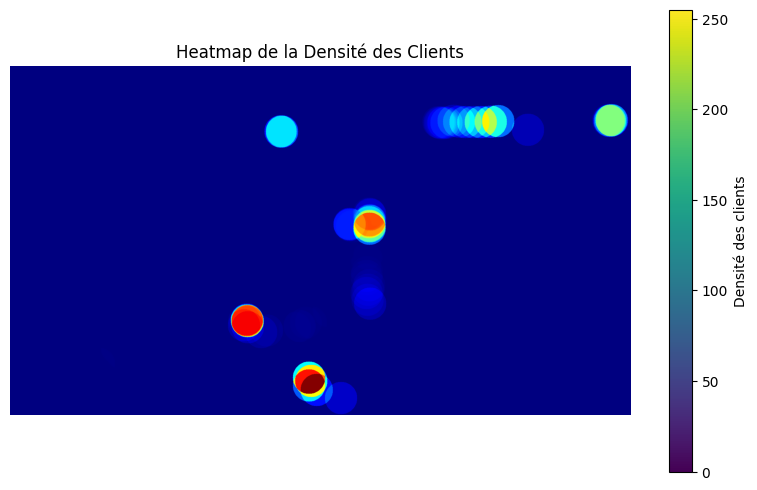

In [7]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Open video
video_path = "/content/drive/MyDrive/Data Traking/people-are-shopping-in-a-garden-market-in-canada-for-fruits-and-meats-SBV-347710395-preview.mp4"
cap = cv2.VideoCapture(video_path)

# Get frame properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video (MP4 with correct codec)
output_path = "heatmap_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4 codec
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Accumulate heatmap
heatmap_accumulated = np.zeros((frame_height, frame_width), dtype=np.float32)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 10 != 0:
        continue

    with torch.no_grad():
        results = model(frame)

    # Create temporary heatmap
    heatmap = np.zeros((frame_height, frame_width), dtype=np.float32)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            conf = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0].cpu().numpy())

            if class_id == 0:
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                cv2.circle(heatmap, (cx, cy), 50, conf, -1)

    # Accumulate and normalize heatmap
    heatmap_accumulated *= 0.95
    heatmap_accumulated = cv2.addWeighted(heatmap_accumulated, 0.8, heatmap, 0.2, 0)

    heatmap_norm = cv2.normalize(heatmap_accumulated, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_norm), cv2.COLORMAP_JET)

    # Overlay heatmap on original frame
    blended = cv2.addWeighted(frame, 0.6, heatmap_color, 0.4, 0)

    out.write(blended)

# Clean up
cap.release()
out.release()
#cv2.destroyAllWindows()

# Save last frame and visualizations
cv2.imwrite("heatmap_transparent.png", heatmap_color)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB))
plt.colorbar(label="Densité des clients")
plt.title("Heatmap de la Densité des Clients")
plt.axis("off")
plt.savefig("heatmap_transparent_visual.png")

# Download files
print("✅ Fichier généré correctement.")
files.download("heatmap_output.mp4")
files.download("heatmap_transparent.png")
files.download("heatmap_transparent_visual.png")

## **simple tracker using object centroids**

In [8]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from collections import defaultdict

# Load YOLOv8
model = YOLO("yolov8n.pt")

# Video input
video_path = "/content/drive/MyDrive/Data Traking/people-are-shopping-in-a-garden-market-in-canada-for-fruits-and-meats-SBV-347710395-preview.mp4"
cap = cv2.VideoCapture(video_path)

# Output video config
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("tracking_lines_output.mp4", fourcc, fps, (frame_width, frame_height))

# Object ID counter and tracking data
next_id = 0
track_history = defaultdict(list)  # {id: [(x, y), ...]}

# Euclidean distance function
def get_closest_id(center, objects, threshold=50):
    for object_id, prev_center in objects.items():
        if np.linalg.norm(np.array(center) - np.array(prev_center)) < threshold:
            return object_id
    return None

# Last known locations of tracked objects
tracked_objects = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    with torch.no_grad():
        results = model(frame)[0]

    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf[0].cpu().numpy())
        class_id = int(box.cls[0].cpu().numpy())

        if class_id == 0:  # Only people
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            detections.append(((x1, y1, x2, y2), (cx, cy)))

    updated_objects = {}
    for bbox, center in detections:
        matched_id = get_closest_id(center, tracked_objects)

        if matched_id is None:
            matched_id = next_id
            next_id += 1

        updated_objects[matched_id] = center
        track_history[matched_id].append(center)

        # Draw bounding box
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f'ID {matched_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Draw tracking lines
    for object_id, centers in track_history.items():
        for i in range(1, len(centers)):
            cv2.line(frame, centers[i - 1], centers[i], (0, 255, 0), 2)

    # Update tracker
    tracked_objects = updated_objects.copy()

    out.write(frame)

cap.release()
out.release()
print("✅ Tracking video with movement lines saved as tracking_lines_output.mp4")



0: 384x640 5 persons, 128.9ms
Speed: 5.1ms preprocess, 128.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 125.2ms
Speed: 3.9ms preprocess, 125.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 129.0ms
Speed: 5.6ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 135.8ms
Speed: 4.5ms preprocess, 135.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 123.6ms
Speed: 3.8ms preprocess, 123.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 137.2ms
Speed: 4.3ms preprocess, 137.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 131.5ms
Speed: 3.7ms preprocess, 131.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 123.7ms
Speed: 3.8ms preprocess, 123.7ms inference, 1.0ms postprocess per 

In [9]:
files.download("tracking_lines_output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Exporting the data to an Excel file

What You’ll Export==>
Each row in the Excel will include:

1-Frame Number

2- Object ID

3- X, Y position (center of person)

4- Total Steps

5- trajectory length

In [10]:
!pip install openpyxl


In [11]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from collections import defaultdict
import pandas as pd

# Load YOLOv8
model = YOLO("yolov8n.pt")

# Video input
video_path = "/content/drive/MyDrive/Data Traking/people-are-shopping-in-a-garden-market-in-canada-for-fruits-and-meats-SBV-347710395-preview.mp4"
cap = cv2.VideoCapture(video_path)

# Output video config
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("tracking_lines_output.mp4", fourcc, fps, (frame_width, frame_height))

# Tracker data
next_id = 0
track_history = defaultdict(list)        # {id: [(x, y), ...]}
trajectory_lengths = defaultdict(float)  # {id: total_distance}
tracked_objects = {}

# Excel export list
export_data = []

# Euclidean distance
def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def get_closest_id(center, objects, threshold=50):
    for object_id, prev_center in objects.items():
        if euclidean(center, prev_center) < threshold:
            return object_id
    return None

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_number += 1

    with torch.no_grad():
        results = model(frame)[0]

    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        class_id = int(box.cls[0].cpu().numpy())

        if class_id == 0:  # Person
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            detections.append(((x1, y1, x2, y2), (cx, cy)))

    updated_objects = {}
    for bbox, center in detections:
        matched_id = get_closest_id(center, tracked_objects)

        if matched_id is None:
            matched_id = next_id
            next_id += 1

        updated_objects[matched_id] = center

        # Update track history and distance
        history = track_history[matched_id]
        if history:
            last_point = history[-1]
            dist = euclidean(center, last_point)
            trajectory_lengths[matched_id] += dist

        track_history[matched_id].append(center)

        # Save data for Excel
        export_data.append({
            "Frame": frame_number,
            "ID": matched_id,
            "X": center[0],
            "Y": center[1],
            "Total Steps": len(track_history[matched_id]),
            "Trajectory Length": round(trajectory_lengths[matched_id], 2)
        })

        # Draw visuals
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f'ID {matched_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Draw tracking lines
    for object_id, centers in track_history.items():
        for i in range(1, len(centers)):
            cv2.line(frame, centers[i - 1], centers[i], (0, 255, 0), 2)

    tracked_objects = updated_objects.copy()
    out.write(frame)

cap.release()
out.release()

# Export to Excel
df = pd.DataFrame(export_data)
excel_path = "tracking_data_with_steps.xlsx"
df.to_excel(excel_path, index=False)
print(f"Excel with trajectory data saved: {excel_path}")



0: 384x640 5 persons, 131.4ms
Speed: 5.9ms preprocess, 131.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 143.1ms
Speed: 5.0ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 127.7ms
Speed: 5.4ms preprocess, 127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 127.8ms
Speed: 4.6ms preprocess, 127.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 124.3ms
Speed: 4.3ms preprocess, 124.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 122.6ms
Speed: 3.8ms preprocess, 122.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 135.1ms
Speed: 3.8ms preprocess, 135.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 139.1ms
Speed: 4.1ms preprocess, 139.1ms inference, 1.2ms postprocess per 

In [12]:
files.download("tracking_data_with_steps.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>